In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
# === CLASS ENCODING ===
# NO_ACTION = 0
# SHIELD = 1
# GRENADE = 2
# RELOAD = 3
# ENDING = 4

# === RAW DATA ===
# AccX
# AccY
# AccZ
# GyroX 
# GyroY
# GyroZ

In [3]:
DATA_DIR = 'data'
RAW = DATA_DIR + '/raw'

In [4]:
def mean(data):
    return np.mean(data)

def std(data):
    return np.std(data)

def iqr(data):
    '''
    calculate interquartile range
    '''
    q3, q1 = np.percentile(data, [75 ,25])
    return q3 - q1 

def mad(data, axis=None):
    '''
    calculate mean absolute deviation
    '''
    return np.mean(np.absolute(data - np.mean(data, axis)), axis)

In [5]:
sample_data = [[] for _ in range(6)]
    
with open(f'{RAW}/s1r1.txt', 'r') as f:
    lines = f.readlines()
    for line in lines:
        data_point = map(float, line.split(','))
        for i, n in enumerate(data_point):
            sample_data[i].append(n)

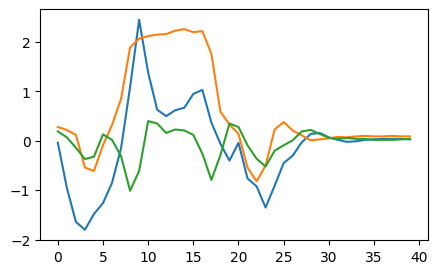

In [6]:
plt.figure(figsize=(5,3))
plt.plot(sample_data[0])
plt.plot(sample_data[1])
plt.plot(sample_data[2])
plt.show()

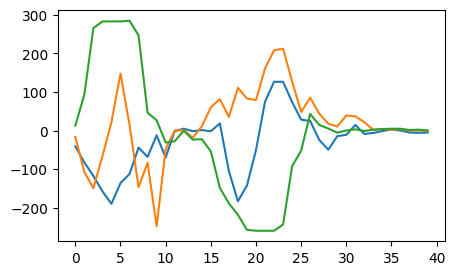

In [7]:
plt.figure(figsize=(5,3))
plt.plot(sample_data[3])
plt.plot(sample_data[4])
plt.plot(sample_data[5])
plt.show()

In [8]:
action_mapping = {'n': 0, 's':1, 'g':1, 'r':1, 'e':1}
data = []

for filename in os.listdir(RAW):
    if filename[-3:] == 'txt':
        single_action = [[] for _ in range(6)]
        single_action_tranform = []
        action = action_mapping[filename[0]]

        with open(f'{RAW}/{filename}', 'r') as f:
            lines = f.readlines()
            for line in lines:
                data_point = map(float, line.split(','))
                for i, n in enumerate(data_point):
                    single_action[i].append(n)

        for s in single_action:
            single_action_tranform.append(max(s))
            single_action_tranform.append(min(s))
            single_action_tranform.append(mean(s))
            single_action_tranform.append(std(s))
            single_action_tranform.append(iqr(s))    
            single_action_tranform.append(mad(s))
        single_action_tranform.append(action)
        data.append(single_action_tranform)

In [9]:
df = pd.DataFrame.from_records(data)
df.rename(columns={36:'action'}, inplace=True)
df

,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,action
0,0.36,-0.55,-0.05600,0.185119,0.1950,0.130600,0.64,-0.48,0.25375,0.257320,...,80.368929,80.2675,56.665587,121.83,-95.63,13.76900,42.400523,49.8475,33.102700,1
1,0.27,-0.87,-0.14800,0.254649,0.2225,0.185700,1.52,-0.50,0.44200,0.521743,...,112.241522,48.8600,71.131312,190.10,-260.28,-13.01025,105.625801,36.0025,70.917362,1
2,0.33,-0.53,-0.14900,0.146404,0.1700,0.105850,0.72,-0.16,0.15075,0.171528,...,76.686632,83.3700,59.485000,89.31,-108.33,-7.60725,50.283531,72.3000,42.688887,0
3,1.50,-1.55,-0.06300,0.609972,0.3225,0.401250,1.11,-1.15,0.22175,0.405659,...,138.872482,120.0750,99.343000,281.23,-262.20,12.69025,135.262757,70.5675,91.095287,1
4,1.02,-0.97,-0.01675,0.458538,0.7300,0.365262,2.18,-0.32,0.99075,0.931787,...,36.193719,33.6675,25.940337,284.11,-260.36,-4.40900,139.008743,57.2375,91.772300,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
815,0.39,-0.35,0.02675,0.153059,0.1350,0.112575,0.66,-1.02,0.04250,0.356495,...,72.404782,91.1800,57.478900,71.01,-91.09,-4.75550,40.281401,38.2600,31.007825,1
816,0.34,-1.00,-0.12025,0.262188,0.2600,0.194300,0.83,-0.52,0.21800,0.368356,...,102.237077,113.3925,77.303350,104.92,-126.67,5.77550,32.352100,24.1950,19.308550,1
817,0.27,-0.53,-0.04775,0.189043,0.1775,0.142687,0.80,-0.73,0.13675,0.381264,...,89.864131,112.5975,69.491700,101.75,-81.96,5.18500,32.436483,25.8550,22.660000,1
818,1.97,-1.85,-0.01875,0.703176,0.3450,0.453937,2.01,-0.81,0.18175,0.666963,...,93.175881,77.4625,65.056800,284.73,-260.74,-6.90700,146.795926,46.2175,95.748100,1


## Train model

In [10]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [11]:
NUM_FEATURES = 36

In [12]:
X = df[[x for x in range(NUM_FEATURES)]]
y = df['action']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.85, random_state=42, shuffle=True
)

X_train.reset_index(inplace=True, drop=True)
X_test.reset_index(inplace=True, drop=True)
y_train.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True, drop=True)

In [14]:
train_df = X_train.copy()
train_df['action'] = y_train
test_df = X_test.copy()
test_df['action'] = y_test

# train_df.to_csv(f'{DATA_DIR}/train.csv', index=False)
# test_df.to_csv(f'{DATA_DIR}/test.csv', index=False)

In [15]:
len(y_train), len(y_test)

(697, 123)

In [16]:
input_size = 36
hidden_size = 10
num_classes = 2
num_epochs = 200
batch_size = 20
learning_rate = 0.01
device = torch.device('cpu')

In [17]:
class ImuDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __getitem__(self, index):
        return torch.Tensor(self.X.iloc[index].astype(float)), self.y[index]
    
    def __len__(self):
        return len(self.X)

In [18]:
train_dataset = ImuDataset(X_train, y_train)
test_dataset = ImuDataset(X_test, y_test)

train_loader = DataLoader(
    dataset=train_dataset, 
    batch_size=batch_size, 
    shuffle=True
)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False
)

In [19]:
class FCN(nn.Module):
    '''
    Fully connected network (MLP) with one hidden layer using ReLU activation function
    '''
    def __init__(self, input_size, hidden_size, num_classes):
        super(FCN, self).__init__()
        self.input_size = input_size
        self.l1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out) 
        return out

In [20]:
model = FCN(input_size, hidden_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sb

def test_conf_matrix(benchmark_loader, is_test_set=False):
    y_pred = []
    y_true = []
    
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        for data, labels in benchmark_loader:
            labels = labels.to(device)
            y_true.extend(labels)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            y_pred.extend(predicted)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()

        acc = 100.0 * n_correct / n_samples
        if is_test_set:
            print(f'Accuracy on test set: {acc:.4f}%')
        else:
            print(f'Accuracy on train set: {acc:.4f}%')
        
        cf_mat = confusion_matrix(y_true, y_pred)
        cm_df = pd.DataFrame(cf_mat, index=[i for i in range(num_classes)], columns=[i for i in range(num_classes)])
        plt.figure(figsize=(4,3))
        sb.heatmap(cm_df, annot=True)

Before training
Accuracy on train set: 27.1162%
Accuracy on test set: 25.2033%


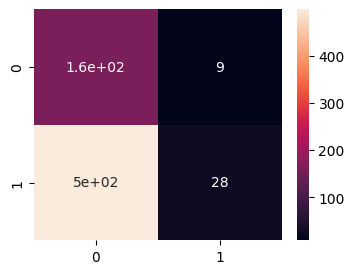

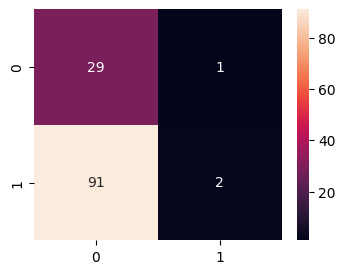

In [22]:
print('Before training')
test_conf_matrix(train_loader)
test_conf_matrix(test_loader, True)

In [23]:
losses = [] # to record loss over training time

for epoch in range(num_epochs):
    for i, (data, label) in enumerate(train_loader):
        label = label.to(device)
        output = model(data)
        loss = criterion(output, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    
    scheduler.step()

    if epoch % 200  == 0:
        print(f'Epoch {epoch+1}/{num_epochs}: loss = {loss.item():.4f}', end='; ')
        print(f"learning rate = {optimizer.param_groups[0]['lr']}")

Epoch 1/200: loss = 0.5637; learning rate = 0.01


After training
Accuracy on train set: 97.7044%
Accuracy on test set: 96.7480%


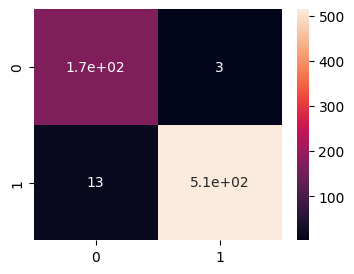

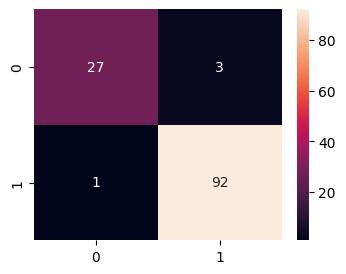

In [24]:
print('After training')
test_conf_matrix(train_loader)
test_conf_matrix(test_loader, True)

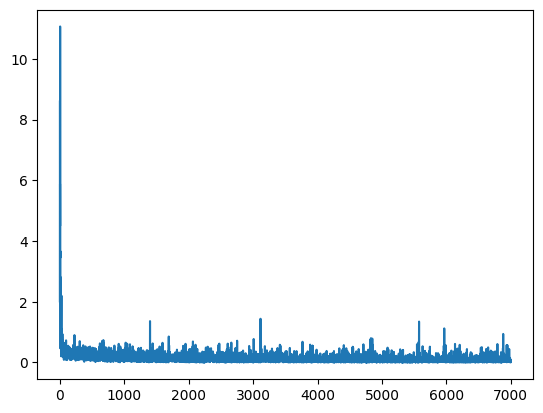

In [25]:
plt.plot(losses)

In [26]:
# torch.save(model, 'full_model.pth')

## Visualization

In [28]:
na_df = df[df['action'] == 0]
action_df = df[df['action'] == 1]

In [52]:
action_mapping = {'n': 0, 's':1, 'g':1, 'r':1, 'e':1}
na_gyrosq = []
a_gyrosq = []

for filename in os.listdir(RAW):
    if filename[-3:] == 'txt':
        single_action = [[] for _ in range(6)]
        single_action_tranform = []
        action = action_mapping[filename[0]]

        with open(f'{RAW}/{filename}', 'r') as f:
#             lines = f.readlines()
            line = f.readline().rstrip()
#             for line in lines:/
            data_point = list(map(float, line.split(',')))
            if action == 1:
                a_gyrosq.append(data_point[-1]**2 + data_point[-2]**2 + data_point[-3]**2)
            else:
                na_gyrosq.append(data_point[-1]**2 + data_point[-2]**2 + data_point[-3]**2)

[Text(1, 0, 'no_action'), Text(2, 0, 'action')]

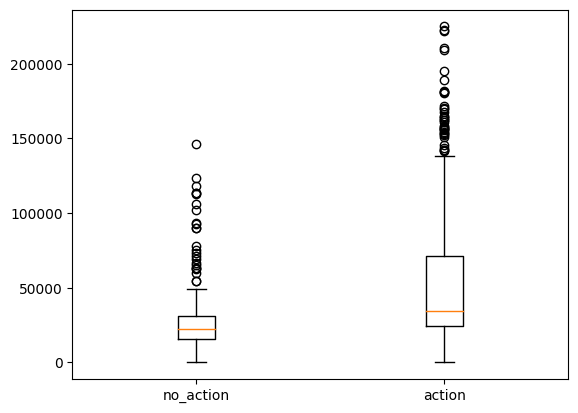

In [53]:
gyrosq = {'no_action': na_gyrosq, 'action': a_gyrosq}

fig, ax = plt.subplots()
ax.boxplot(gyrosq.values())
ax.set_xticklabels(gyrosq.keys())